# Lognormal price process #
每步对数收益\
$
r_t=\log\frac{P_t}{P_{t-1}} \sim N(\mu\Delta t,\ \sigma^2\Delta t)
$\
价格更新\
$
P_t=P_{t-1}e^{r_t}
$\
等价的对数价格累加形式\
令 $s_t=\log P_t$，则\
$s_t=s_{t-1}+r_t$
$\Rightarrow s_T=s_0+\sum_{t=1}^T r_t$
所以\
$s_T \sim N\big(s_0+T\mu\Delta t,\ T\sigma^2\Delta t\big)$

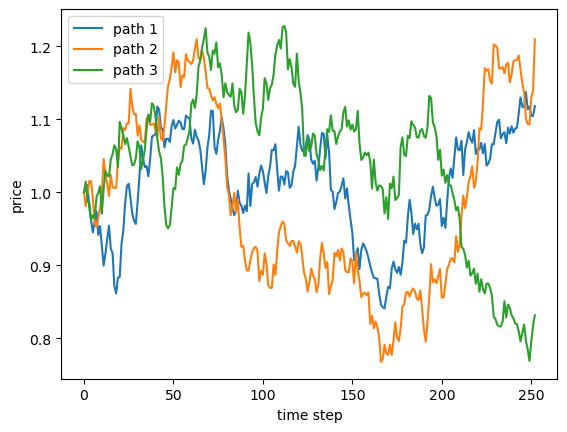

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_lognormal_paths(
    mu=0.10, sigma=0.30, dt=1 / 252, Nt=252, Np=10000, P0=1.0, seed=0
):
    """
    Discrete-time lognormal model:
      r_t = log(P_t/P_{t-1}) ~ N(mu*dt, sigma^2*dt)
      P_t = P_{t-1} * exp(r_t)

    mu, sigma: annualized
    dt: step size in years (1/252 for daily)
    Nt: number of steps
    Np: number of paths
    """
    rng = np.random.default_rng(seed)

    # z ~ N(0,1), shape (Nt, Np)
    z = rng.standard_normal((Nt, Np))

    # r = mu*dt + sigma*sqrt(dt)*z, shape (Nt, Np)
    r = mu * dt + sigma * np.sqrt(dt) * z

    # s = log P, start at log(P0)
    s = np.empty((Nt + 1, Np))
    s[0, :] = np.log(P0)

    # cumulative sum of log returns
    s[1:, :] = s[0, :] + np.cumsum(r, axis=0)

    # back to price
    P = np.exp(s)
    return P


# Example: simulate and plot first 3 paths
P = simulate_lognormal_paths(
    mu=0.10, sigma=0.30, dt=1 / 252, Nt=252, Np=10000, P0=1.0, seed=42
)

plt.figure()
plt.plot(P[:, 0], label="path 1")
plt.plot(P[:, 1], label="path 2")
plt.plot(P[:, 2], label="path 3")
plt.xlabel("time step")
plt.ylabel("price")
plt.legend()
plt.show()


MC mean(R): 0.15940020227466292
Theory mean(R): 0.15603957026802173
MC sd(R): 0.3565859656459355
Theory sd(R): 0.3547634442959879


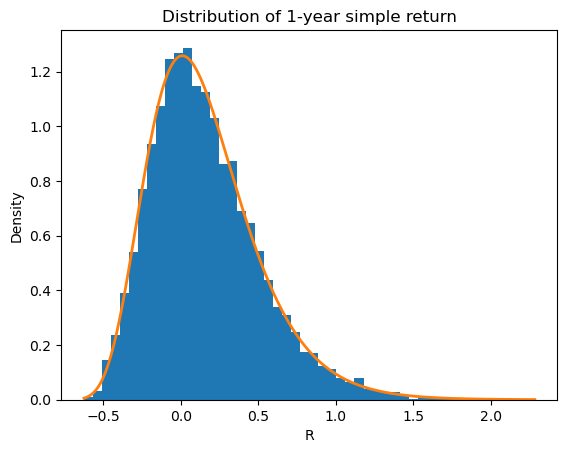

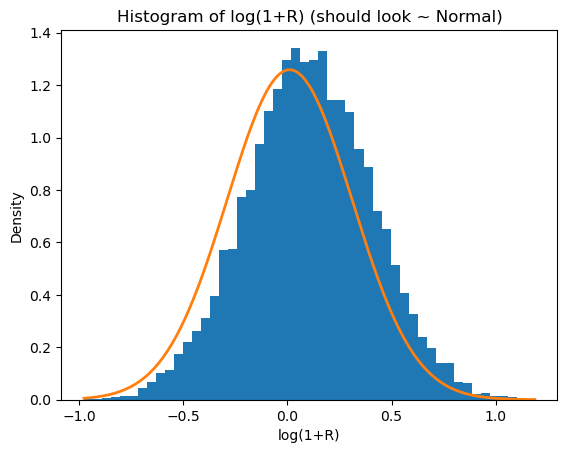

In [ ]:
# ---- 1) simulate prices ----
mu_ann = 0.10
sigma_ann = 0.30
dt = 1 / 252
Nt = 252
Np = 20000
P0 = 1.0

# ---- 2) 1-year simple return R = P_T/P0 - 1 ----
PT = P[-1, :]  # shape (Np,)
R = PT / P0 - 1  # if P0==1, equals PT-1

# ---- 3) Monte Carlo stats vs theory ----
mc_mean = R.mean()
mc_sd = R.std(ddof=0)

# For T=1 year: log-return r(T) ~ N(mu, sigma^2) where mu=mu_ann, sigma=sigma_ann
theory_mean = np.exp(mu_ann + 0.5 * sigma_ann**2) - 1
theory_var = np.exp(2 * mu_ann + sigma_ann**2) * (np.exp(sigma_ann**2) - 1)
theory_sd = np.sqrt(theory_var)

print("MC mean(R):", mc_mean)
print("Theory mean(R):", theory_mean)
print("MC sd(R):", mc_sd)
print("Theory sd(R):", theory_sd)

# ---- 4) Histogram of 1-year simple return + red fitted curve ----
# 1+R = PT/P0 is lognormal with parameters (mu, sigma) for T=1 year
x = np.linspace(R.min(), R.max(), 500)
y = 1 + x

# lognormal pdf of Y=1+R:
# f_Y(y) = 1/(y*sigma*sqrt(2pi)) * exp(-(ln y - mu)^2/(2sigma^2)), y>0
pdf_y = np.zeros_like(y)
mask = y > 0
pdf_y[mask] = (1 / (y[mask] * sigma_ann * np.sqrt(2 * np.pi))) * np.exp(
    -((np.log(y[mask]) - mu_ann) ** 2) / (2 * sigma_ann**2)
)

# Since x = y - 1, pdf_R(x) = pdf_Y(1+x)
pdf_r = pdf_y

plt.figure()
plt.hist(R, bins=50, density=True)
plt.plot(x, pdf_r, linewidth=2)
plt.title("Distribution of 1-year simple return")
plt.xlabel("R")
plt.ylabel("Density")
plt.show()

# ---- 5) (optional) diagnostics like the slide ----
plt.figure()
plt.hist(np.log(1 + R), bins=50, density=True)
plt.plot(np.log(1 + x), pdf_r, linewidth=2)
plt.title("Histogram of log(1+R) (should look ~ Normal)")
plt.xlabel("log(1+R)")
plt.ylabel("Density")
plt.show()


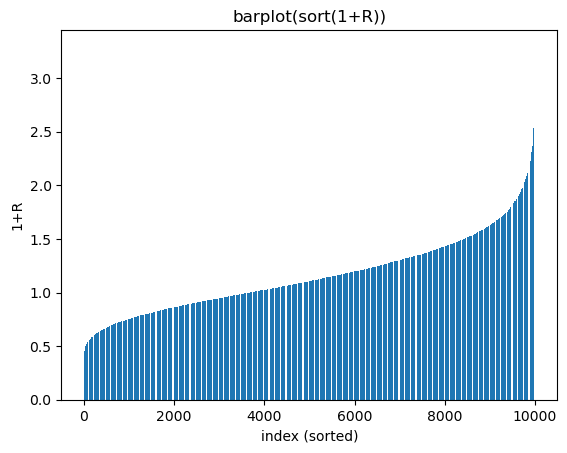

In [15]:
y = np.sort(1 + R)
plt.figure()
plt.bar(np.arange(len(y)), y)
plt.title("barplot(sort(1+R))")
plt.xlabel("index (sorted)")
plt.ylabel("1+R")
plt.show()

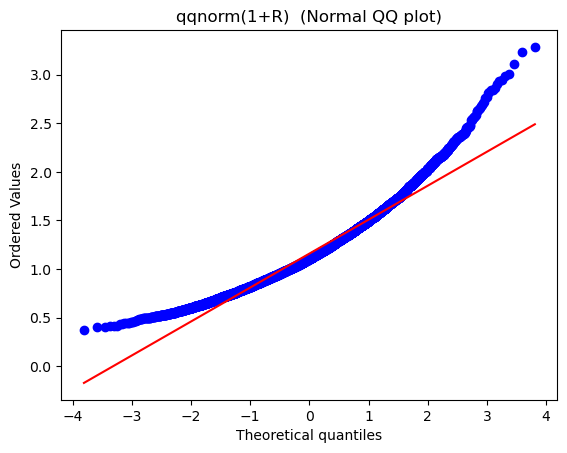

In [14]:
from scipy import stats

stats.probplot(1 + R, dist="norm", plot=plt)
plt.title("qqnorm(1+R)  (Normal QQ plot)")
plt.show()
